In [10]:
from functions import *

In [11]:
# find the difference in hours to a historic time
# use that to query the data base.
time_since('Time: 2025-04-17 03:19:42 EDT')

67.825065515

https://scdms-monitor.tes-uoft.com/snolab/api/query?table=temp&startDate=2025-04-19T11:29:38&endDate=2025-04-19T17:29:38
https://scdms-monitor.tes-uoft.com/snolab/api/query?table=fridge&startDate=2025-04-19T11:29:38&endDate=2025-04-19T17:29:38


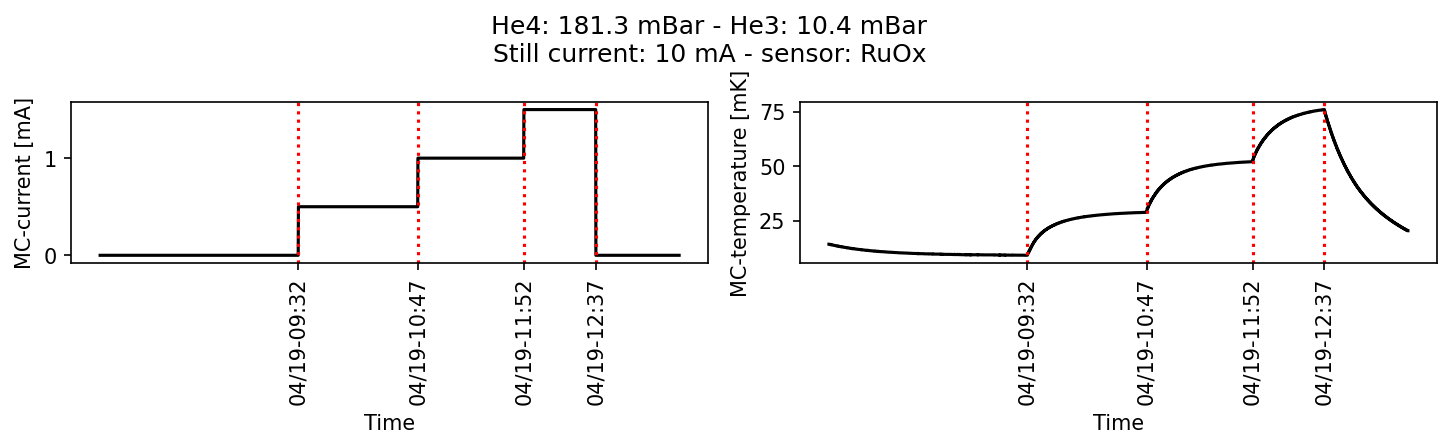

In [37]:
# First, run this and make sure to select one full cycle of the temperature scan—from rise to fall
# The first and second numbers should enclose a full scan cycle. Otherwise Functionalities in the next cell won't work.

queries = get_temp_info([16,10])
save_to_text(queries,file_name = 'output_data.txt')

https://scdms-monitor.tes-uoft.com/snolab/api/query?table=temp&startDate=2025-04-19T10:32:41&endDate=2025-04-19T17:37:50
https://scdms-monitor.tes-uoft.com/snolab/api/query?table=fridge&startDate=2025-04-19T10:32:41&endDate=2025-04-19T17:37:50


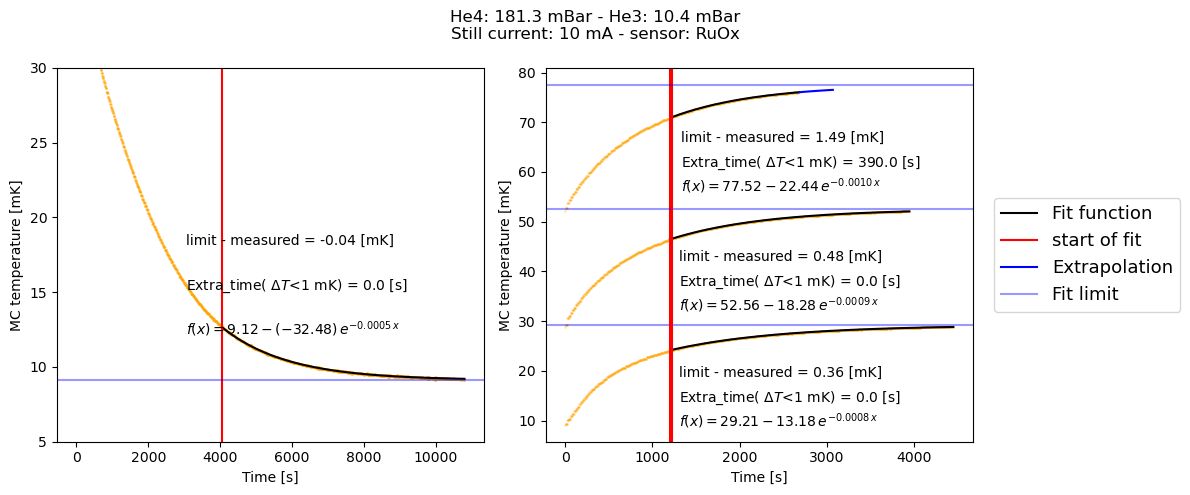

In [38]:
# Give the address of the output this cell.

start, end = time_diff_from_log('output_data.txt')

'''
CMN
RuOx
'''
sensor = 'RuOx'
# Make sure the lower time bound doesn't go into a previous MC current change. That messes up the plots below.
# Even if that doesn't show up in the plot above, there is chance that the current change be within the range that the code selects.
# choose time manually to prevent that issue.
time_array = get_time(start, end)
temp_down, temp_up = get_temp_data(time_array)

skipe_samples = 300
fig, ax = plt.subplots(1,2, dpi =100,figsize=(12,5))
fitted_temp = []
power = []


for key, data in temp_up.items():
    He4, He3, ST_current, MC_current = key
    x,y = get_xy(data, sensor)    
    params, extra_time, temp_unc = do_fit(saturating_exp,x[skipe_samples:],y[skipe_samples:],ax[1])
    ax[1].scatter(x,y,alpha=0.2,s=1,label='Data',c = 'orange')
    
    fitted_temp.append(params[0])
    power.append(100*MC_current**2)
    
ax[1].legend(['Fit function','start of fit','Extrapolation','Fit limit'],bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0,fontsize = 13)

skipe_samples = 1000

for key, data in temp_down.items():
    He4, He3, ST_current, MC_current = key
    x,y = get_xy(data,sensor)
    params, extra_time, temp_unc = do_fit_downward(saturating_exp,x[skipe_samples:],y[skipe_samples:],ax[0])
    ax[0].scatter(x,y,alpha=0.2,s=1,label='Data',c = 'orange')
    fitted_temp.insert(0,params[0])
    power.insert(0,100*MC_current**2)
    
# plt.legend(['Fit function','start of fit','Extrapolation','Fit limit'],bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0,fontsize = 13)
fig.suptitle(f'He4: {He4:.1f} mBar - He3: {He3:.1f} mBar\nStill current: {ST_current} mA - sensor: {sensor}' )
fig.tight_layout()
plt.savefig(f'He4{He4:.1f}-He3{He3:.1f}-StillCurrent{ST_current}-{sensor}-fit.jpg')
    

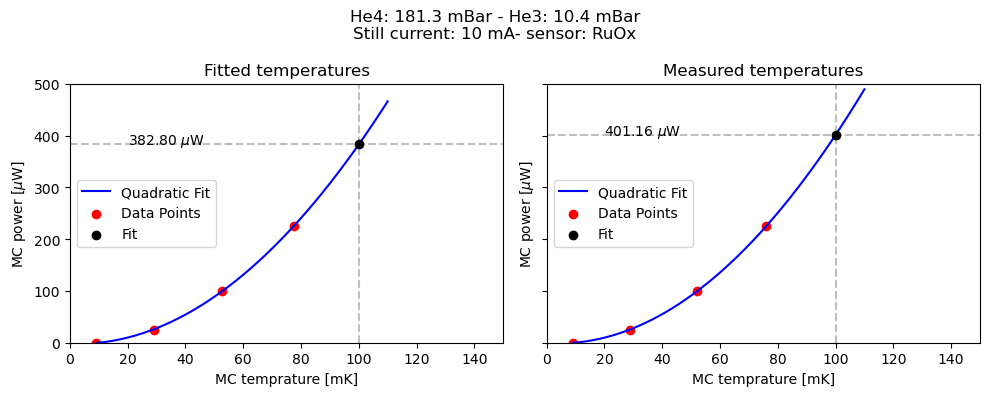

In [39]:
fig,ax = plt.subplots(1,2,sharey=True,dpi =100,figsize= (10,4))
fig.suptitle(f'He4: {He4:.1f} mBar - He3: {He3:.1f} mBar\nStill current: {ST_current} mA- sensor: {sensor}' ),
y_eval_fit = fit_quadratic_and_plot(fitted_temp, 
                                    power, 
                                    100,
                                    "Fitted temperatures",
                                    ax[0])    

measured_tmp = extract_mc_values('output_data.txt',
                                 sensor=sensor)

y_eval_measured = fit_quadratic_and_plot(measured_tmp, 
                                         power, 
                                         100,
                                         "Measured temperatures",
                                         ax[1])    
plt.savefig(f'He4{He4:.1f}-He3{He3:.1f}-StillCurrent{ST_current}-{sensor}-power.jpg')



In [35]:
csv_file = 'fridge_log.csv'
for row in list(queries.values()):
    row['MC power fit [uW]'] = np.round(y_eval_fit,2)
    row['MC power measured [uW]'] = np.round(y_eval_measured,2)
    write_csv('fridge_log.csv',row)

make_pretty_table('fridge_log.csv')

✔️ Table with dynamic column spacing saved to 'pretty_table.txt'
